# Unsupervised approach to Tri Health Data

In [121]:
import pandas as pd

df = pd.read_csv('tri_health_data.csv')
df.head(5)

,Date,Sleep,Activity Type,Activity Duration,TSS,Weight,HRV,Steps,Cals_burnt,Cals,Carbs,Fats,Protein,Sensation
0,22/05/2017,7.1,"Swim, Run",125.0,154,87.7,NaN,13894.0,4600.0,3600.0,NaN,NaN,135.0,7.0
1,23/05/2017,6.3,Swim,45.0,78,NaN,NaN,12739.0,3459.0,3700.0,NaN,NaN,75.0,4.0
2,24/05/2017,6.7,NaN,NaN,0,NaN,NaN,3324.0,2629.0,2210.0,NaN,NaN,75.0,8.0
3,25/05/2017,7.6,"Swim, Gym",142.0,155,NaN,NaN,11532.0,4327.0,4580.0,NaN,NaN,120.0,7.0
4,26/05/2017,8.7,Run,68.0,60,NaN,NaN,10479.0,3363.0,3590.0,NaN,NaN,80.0,9.0


In [122]:
# 1. Drop the columns 'Fats', 'Carbs', and 'HRV'.
df.drop(columns=['Fats', 'Carbs', 'HRV'], inplace=True)

# 2. Forward-fill the missing values in the 'Weight' column.
df['Weight'].fillna(method='ffill', inplace=True)

# 3. Fill the missing values in the 'Protein' column with its median, or with 80 if the median is NaN.
protein_median = df['Protein'].median()
if pd.isna(protein_median):
    df['Protein'].fillna(value=80, inplace=True)
else:
    df['Protein'].fillna(value=protein_median, inplace=True)

# 4. Fill any missing values in the 'Cals' column with its 75th percentile value.
df['Cals'].fillna(value=df['Cals'].quantile(0.75), inplace=True)

# 5. Fill any missing values in the 'Sensation' column with its mean value.
df['Sensation'].fillna(value=df['Sensation'].mean(), inplace=True)

# 6. Identify and drop rows where 'Activity Duration' is NaN but 'Activity Type' is not NaN.
rows_to_drop = df[df['Activity Duration'].isna() & ~df['Activity Type'].isna()].index
rows_dropped_count = len(rows_to_drop)
df.drop(rows_to_drop, inplace=True)

# 7. change NaN to value 0
df['Activity Duration'].fillna(value=0, inplace=True)

df['Activity Type'].fillna(value='Rest_Day', inplace=True)

df = df.dropna(subset=['Sleep', 'Steps', 'Cals_burnt'])


rows_dropped_count

2

In [123]:
print(df.head())
print(df.info())


         Date  Sleep Activity Type  Activity Duration  TSS  Weight    Steps  \
0  22/05/2017    7.1     Swim, Run              125.0  154    87.7  13894.0   
1  23/05/2017    6.3          Swim               45.0   78    87.7  12739.0   
2  24/05/2017    6.7      Rest_Day                0.0    0    87.7   3324.0   
3  25/05/2017    7.6     Swim, Gym              142.0  155    87.7  11532.0   
4  26/05/2017    8.7           Run               68.0   60    87.7  10479.0   

   Cals_burnt    Cals  Protein  Sensation  
0      4600.0  3600.0    135.0        7.0  
1      3459.0  3700.0     75.0        4.0  
2      2629.0  2210.0     75.0        8.0  
3      4327.0  4580.0    120.0        7.0  
4      3363.0  3590.0     80.0        9.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014 entries, 0 to 1033
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1014 non-null   object 
 1   Sleep

In [124]:
df = df.drop(columns=['Date'])


In [125]:
encoder = OneHotEncoder(drop='first')
activity_encoded = encoder.fit_transform(df[['Activity Type']]).toarray()
activity_df = pd.DataFrame(activity_encoded, columns=encoder.get_feature_names(['Activity Type']))

# Concatenate to the original dataframe and drop the original 'Activity Type' column
df = pd.concat([df, activity_df], axis=1)
df.drop('Activity Type', inplace=True, axis=1)


/home/matt89code/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [126]:
print(df.head())
print(df.info())


   Sleep  Activity Duration    TSS  Weight    Steps  Cals_burnt    Cals  \
0    7.1              125.0  154.0    87.7  13894.0      4600.0  3600.0   
1    6.3               45.0   78.0    87.7  12739.0      3459.0  3700.0   
2    6.7                0.0    0.0    87.7   3324.0      2629.0  2210.0   
3    7.6              142.0  155.0    87.7  11532.0      4327.0  4580.0   
4    8.7               68.0   60.0    87.7  10479.0      3363.0  3590.0   

   Protein  Sensation  Activity Type_Bike, Gym  Activity Type_Gym  \
0    135.0        7.0                      0.0                0.0   
1     75.0        4.0                      0.0                0.0   
2     75.0        8.0                      0.0                0.0   
3    120.0        7.0                      0.0                0.0   
4     80.0        9.0                      0.0                0.0   

   Activity Type_Rest_Day  Activity Type_Run  Activity Type_Run, Bike  \
0                     0.0                0.0                 

In [127]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_array, columns=df.columns)


In [128]:
print(df_scaled.head())
print(df_scaled.info())


      Sleep  Activity Duration       TSS   Weight     Steps  Cals_burnt  \
0 -0.471531           1.365872  1.727208  0.01854  1.214816    1.755724   
1 -1.402429          -0.415671  0.221949  0.01854  0.881668    0.173192   
2 -0.936980          -1.417789 -1.322922  0.01854 -1.833995   -0.977992   
3  0.110280           1.744450  1.747014  0.01854  0.533521    1.377081   
4  1.390265           0.096522 -0.134560  0.01854  0.229794    0.040043   

       Cals   Protein  Sensation  Activity Type_Bike, Gym  Activity Type_Gym  \
0  0.595689  2.901725   0.070048                -0.113961          -0.239482   
1  0.718274 -0.404905  -1.338906                -0.113961          -0.239482   
2 -1.108251 -0.404905   0.539700                -0.113961          -0.239482   
3  1.797027  2.075068   0.070048                -0.113961          -0.239482   
4  0.583430 -0.129352   1.009352                -0.113961          -0.239482   

   Activity Type_Rest_Day  Activity Type_Run  Activity Type_Run, Bik

In [130]:
print(df_scaled.isnull().sum())


Sleep                           20
Activity Duration               20
TSS                             20
Weight                          20
Steps                           20
Cals_burnt                      20
Cals                            20
Protein                         20
Sensation                       20
Activity Type_Bike, Gym         20
Activity Type_Gym               20
Activity Type_Rest_Day          20
Activity Type_Run               20
Activity Type_Run, Bike         20
Activity Type_Run, Bike, Gym    20
Activity Type_Run, Gym          20
Activity Type_Swim              20
Activity Type_Swim, Gym         20
Activity Type_Swim, Run         20
Activity Type_Swim, Run, Gym    20
dtype: int64


In [131]:
df_scaled.dropna(inplace=True)


/home/matt89code/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/matt89code/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


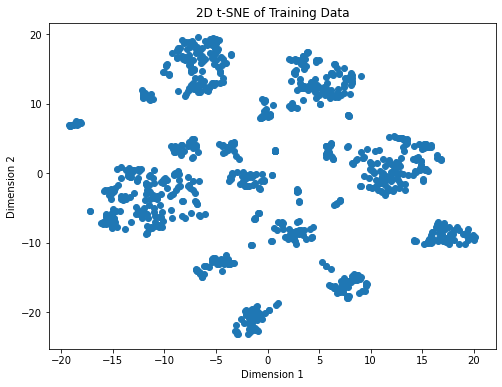

In [132]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
tsne_results = tsne.fit_transform(df_scaled)
tsne_df = pd.DataFrame(data=tsne_results, columns=['Dimension 1', 'Dimension 2'])

# Visualization of t-SNE results
plt.figure(figsize=(8,6))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D t-SNE of Training Data')
plt.show()


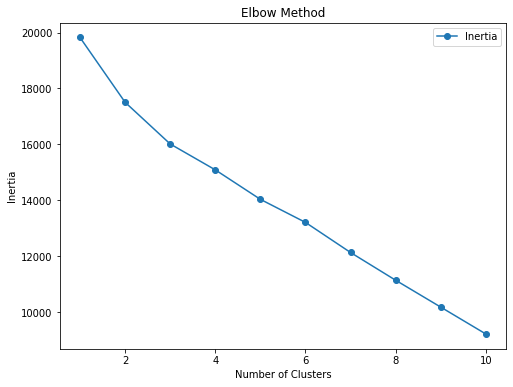

In [133]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(range(1, 11), inertia, 'o-', label="Inertia")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.legend()
plt.show()


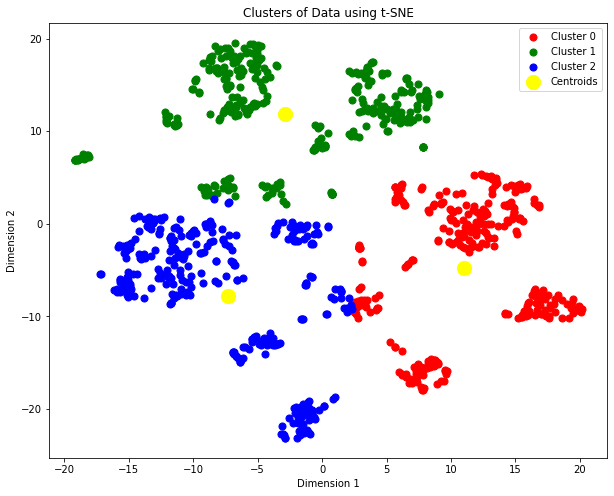

In [144]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_tsne = kmeans.fit_predict(tsne_df)
tsne_df['Cluster'] = clusters_tsne

# Visualization of Clusters
plt.figure(figsize=(10,8))
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter(tsne_df[tsne_df['Cluster'] == i]['Dimension 1'], 
                tsne_df[tsne_df['Cluster'] == i]['Dimension 2'], 
                s = 50, c = colors[i], label = f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c = 'yellow', label = 'Centroids')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('Clusters of Data using t-SNE')
plt.show()

In [145]:
df_reset = df.reset_index(drop=True)
tsne_df_reset = tsne_df.reset_index(drop=True)

for i in range(4):
    print(f"\nCluster {i} Mean Values:")
    print(df_reset[tsne_df_reset['Cluster'] == i].mean())




Cluster 0 Mean Values:


/tmp/ipykernel_2936/1907994006.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_reset[tsne_df_reset['Cluster'] == i].mean())


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [152]:
from sklearn.ensemble import RandomForestRegressor

# Fit a random forest on the dataset
rf = RandomForestRegressor(n_estimators=100)
rf.fit(tsne_df['Cluster'][df.dropna().index])

# Get feature importance
importances = rf.feature_importances_
sorted_idx = importances.argsort()

# Plot
plt.barh(df.drop(columns=["Date", "Activity Type"]).columns[sorted_idx], importances[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()


KeyError: '[994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013] not in index'

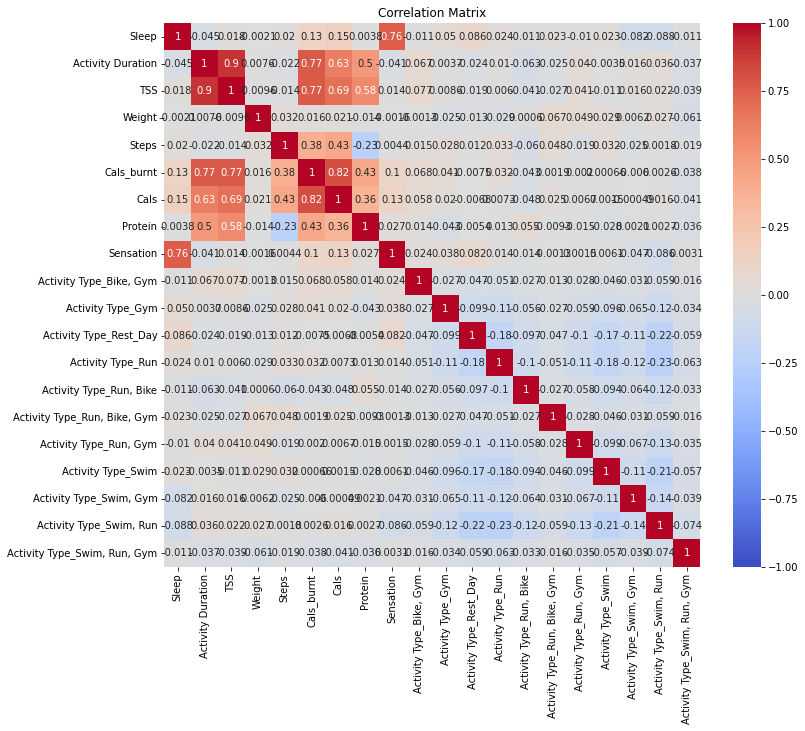

In [150]:
correlations = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


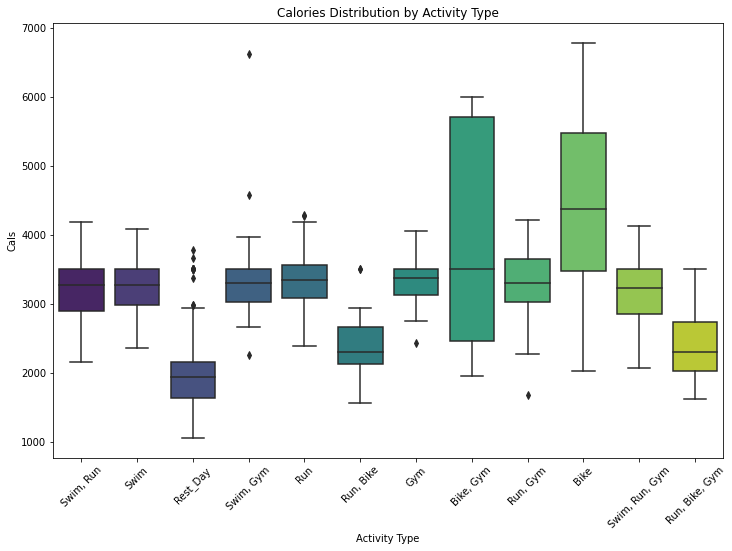

In [43]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Activity Type', y='Cals', palette='viridis')
plt.title('Calories Distribution by Activity Type')
plt.xticks(rotation=45)  # rotate x-axis labels for better visibility if they're lengthy
plt.show()

In [37]:
df['Activity Type'] = df['Activity Type'].str.split(', ')
encoded = pd.get_dummies(df['Activity Type'].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, encoded], axis=1)

/tmp/ipykernel_2936/1646537041.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  encoded = pd.get_dummies(df['Activity Type'].apply(pd.Series).stack()).sum(level=0)


In [38]:
df_filtered = df[(df['Bike'] == 1) | (df['Rest_Day'] == 1)]

In [39]:
scaler = StandardScaler()
df_filtered['Cals_scaled'] = scaler.fit_transform(df_filtered[['Cals']])

# 5. Clustering
kmeans = KMeans(n_clusters=2)
df_filtered['cluster'] = kmeans.fit_predict(df_filtered[['Bike', 'Rest_Day', 'Cals_scaled']])

print(df_filtered[['Date', 'Activity Type', 'Cals', 'cluster']])

            Date Activity Type    Cals  cluster
2     24/05/2017    [Rest_Day]  2210.0        0
5     27/05/2017   [Run, Bike]  2220.0        0
11    02/06/2017    [Rest_Day]  1360.0        0
12    03/06/2017   [Bike, Gym]  2540.0        0
16    07/06/2017    [Rest_Day]  1640.0        0
...          ...           ...     ...      ...
1020  07/03/2020        [Bike]  2810.0        0
1024  11/03/2020    [Rest_Day]  1850.0        0
1027  14/03/2020        [Bike]  3480.0        1
1031  18/03/2020    [Rest_Day]  1790.0        0
1033  20/03/2020    [Rest_Day]  1960.0        0

[286 rows x 4 columns]


/tmp/ipykernel_2936/2819809898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Cals_scaled'] = scaler.fit_transform(df_filtered[['Cals']])
/tmp/ipykernel_2936/2819809898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster'] = kmeans.fit_predict(df_filtered[['Bike', 'Swim', 'Cals_scaled']])


/tmp/ipykernel_2936/3362975970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster'] = kmeans.fit_predict(df_filtered[['Bike', 'Rest_Day', 'Cals_scaled']])


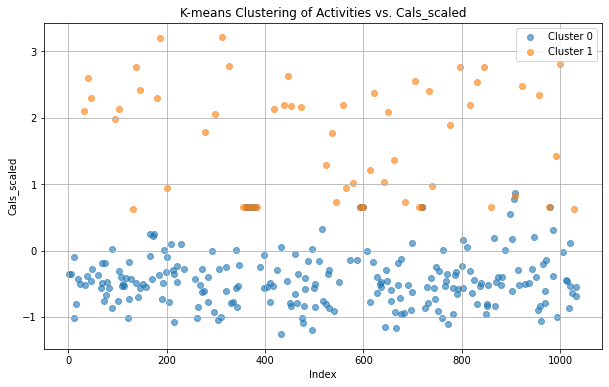

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ... [Your preprocessing code]

# 5. Clustering
kmeans = KMeans(n_clusters=2)
df_filtered['cluster'] = kmeans.fit_predict(df_filtered[['Bike', 'Rest_Day', 'Cals_scaled']])

# Plotting
plt.figure(figsize=(10,6))
for cluster in df_filtered['cluster'].unique():
    subset = df_filtered[df_filtered['cluster'] == cluster]
    plt.scatter(subset.index, subset['Cals_scaled'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-means Clustering of Activities vs. Cals_scaled')
plt.xlabel('Index')
plt.ylabel('Cals_scaled')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2936/1424650776.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  encoded = pd.get_dummies(df['Activity Type'].apply(pd.Series).stack()).sum(level=0)


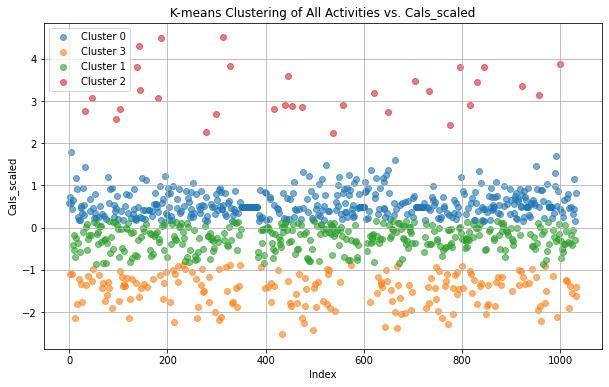

In [53]:
df['Activity Type'] = df['Activity Type'].str.split(', ')
encoded = pd.get_dummies(df['Activity Type'].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, encoded], axis=1)

# 3. Scaling Data
scaler = StandardScaler()
df['Cals_scaled'] = scaler.fit_transform(df[['Cals']])

# 4. Clustering
# Using all activity columns and 'Cals_scaled' for clustering
activity_columns = encoded.columns.tolist()
kmeans = KMeans(n_clusters=4)  # You can adjust the number of clusters if needed
df['cluster'] = kmeans.fit_predict(df[activity_columns + ['Cals_scaled']])

# 5. Plotting
plt.figure(figsize=(10,6))
for cluster in df['cluster'].unique():
    subset = df[df['cluster'] == cluster]
    plt.scatter(subset.index, subset['Cals_scaled'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-means Clustering of All Activities vs. Cals_scaled')
plt.xlabel('Index')
plt.ylabel('Cals_scaled')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
cluster_df = df[['Bike','Gym','Rest_Day','Run','Swim','cluster']]
cluster_df

,Bike,Gym,Rest_Day,Run,Swim,cluster
0,0,0,0,1,1,0
1,0,0,0,0,1,0
2,0,0,1,0,0,3
3,0,1,0,0,1,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
1029,0,0,0,0,1,0
1030,0,0,0,0,1,1
1031,0,0,1,0,0,3
1032,0,0,0,1,1,0


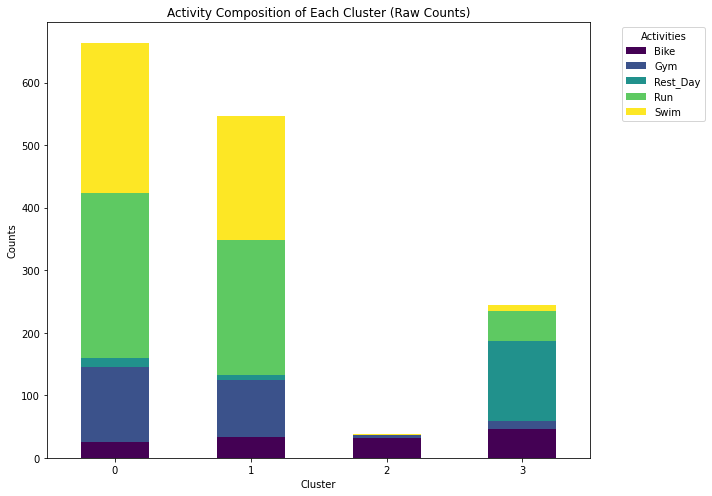

         Bike    Gym  Rest_Day    Run   Swim
cluster                                     
0        25.0  120.0      14.0  264.0  240.0
1        34.0   91.0       7.0  217.0  197.0
2        32.0    5.0       0.0    0.0    1.0
3        46.0   13.0     128.0   48.0    9.0


In [71]:
cluster_activity = cluster_df.groupby('cluster').sum()

# Plotting the stacked bar chart with raw counts
ax = cluster_activity.plot(kind='bar', stacked=True, figsize=(10,7), cmap="viridis")
plt.title('Activity Composition of Each Cluster (Raw Counts)')
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.legend(title="Activities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Displaying the raw counts in a table format
print(cluster_activity)

In [115]:
df

,Sleep,Activity Duration,TSS,Weight,Steps,Cals_burnt,Cals,Protein,Sensation,"Activity Type_Bike, Gym",Activity Type_Gym,Activity Type_Rest_Day,Activity Type_Run,"Activity Type_Run, Bike","Activity Type_Run, Bike, Gym","Activity Type_Run, Gym",Activity Type_Swim,"Activity Type_Swim, Gym","Activity Type_Swim, Run","Activity Type_Swim, Run, Gym"
0,7.1,125.0,154.0,87.7,13894.0,4600.0,3600.0,135.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6.3,45.0,78.0,87.7,12739.0,3459.0,3700.0,75.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,6.7,0.0,0.0,87.7,3324.0,2629.0,2210.0,75.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.6,142.0,155.0,87.7,11532.0,4327.0,4580.0,120.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,8.7,68.0,60.0,87.7,10479.0,3363.0,3590.0,80.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


df = df.drop(columns=['Date'])
df.fillna(df.mean(), inplace=True)
# One-hot encoding
encoder = OneHotEncoder(drop='first')
activity_encoded = encoder.fit_transform(df[['Activity Type']]).toarray()
activity_df = pd.DataFrame(activity_encoded, columns=encoder.get_feature_names(['Activity Type']))

# Concatenate to the original dataframe and drop the original 'Activity Type' column
df = pd.concat([df, activity_df], axis=1)
df.drop('Activity Type', inplace=True, axis=1)


# Scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)



/tmp/ipykernel_2936/3200169397.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)
/home/matt89code/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [119]:
df_scaled = df_scaled.dropna(inplace=True)

In [120]:
print(df_scaled.shape)


AttributeError: 'NoneType' object has no attribute 'shape'

In [112]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
tsne_results = tsne.fit_transform(df_scaled)
tsne_df = pd.DataFrame(data=tsne_results, columns=['Dimension 1', 'Dimension 2'])

# Visualization of t-SNE results
plt.figure(figsize=(8,6))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D t-SNE of Training Data')
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [113]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tsne_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method on t-SNE Data')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

NameError: name 'tsne_df' is not defined

In [114]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_tsne = kmeans.fit_predict(tsne_df)
tsne_df['Cluster'] = clusters_tsne

# Visualization of Clusters
plt.figure(figsize=(10,8))
colors = ['red', 'green', 'blue', 'purple']
for i in range(4):
    plt.scatter(tsne_df[tsne_df['Cluster'] == i]['Dimension 1'], 
                tsne_df[tsne_df['Cluster'] == i]['Dimension 2'], 
                s = 50, c = colors[i], label = f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c = 'yellow', label = 'Centroids')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('Clusters of Data using t-SNE')
plt.show()

NameError: name 'tsne_df' is not defined

In [ ]:
for i in range(4):
    print(f"\nCluster {i} Mean Values:")
    print(df[tsne_df['Cluster'] == i].mean())


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Data Preprocessing
# a) Handling missing data
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Activity Type']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

df_processed = pd.DataFrame(preprocessor.fit_transform(df))
df_processed

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.471531,1.365872,1.727208,0.018540,1.214816,1.755724,0.595689,2.901725,0.070048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.402429,-0.415671,0.221949,0.018540,0.881668,0.173192,0.718274,-0.404905,-1.338906,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.936980,-1.417789,-1.322922,0.018540,-1.833995,-0.977992,-1.108251,-0.404905,0.539700,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.110280,1.744450,1.747014,0.018540,0.533521,1.377081,1.797027,2.075068,0.070048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.390265,0.096522,-0.134560,0.018540,0.229794,0.040043,0.583430,-0.129352,1.009352,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.575729,-0.081632,-0.134560,1.380119,0.521407,0.110778,0.166639,-0.404905,1.479003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1010,0.692092,-0.081632,0.004082,1.380119,0.383244,0.098296,-0.299186,-0.404905,0.539700,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1011,-1.053343,-1.417789,-1.322922,1.380119,-0.925120,-1.724182,-1.623111,-0.129352,-0.399603,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012,1.041178,-0.081632,0.023888,1.380119,0.551693,0.289697,0.816343,-0.129352,1.009352,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


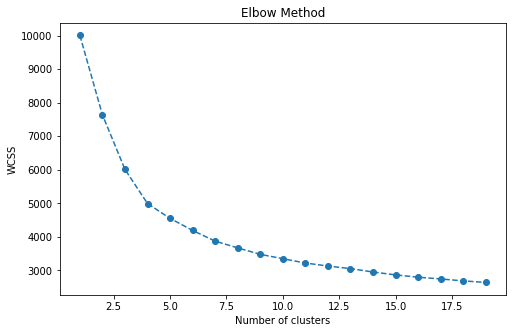

In [5]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_processed)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 20), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [6]:
from sklearn.metrics import silhouette_score

silhouette_score(df_processed, kmeans.labels_)

0.15694435479909172

In [7]:
kmeans.labels_

array([11, 15, 17, ..., 17, 14, 17], dtype=int32)

# Classification of overtraining 

## Learning if over training without the cost of HRV tech

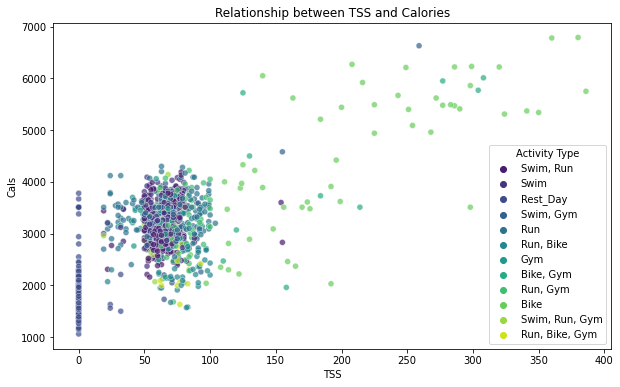

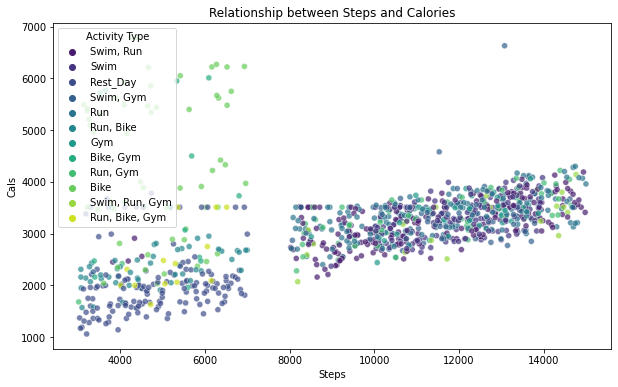

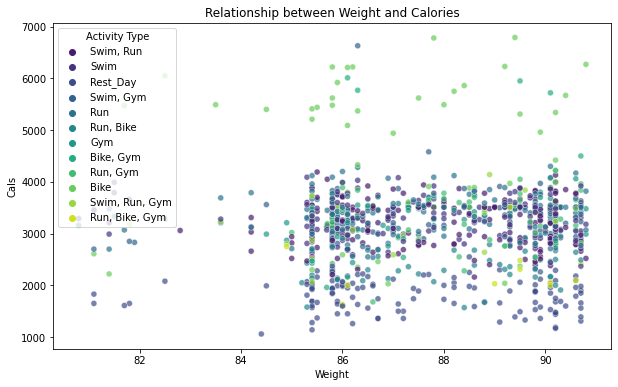

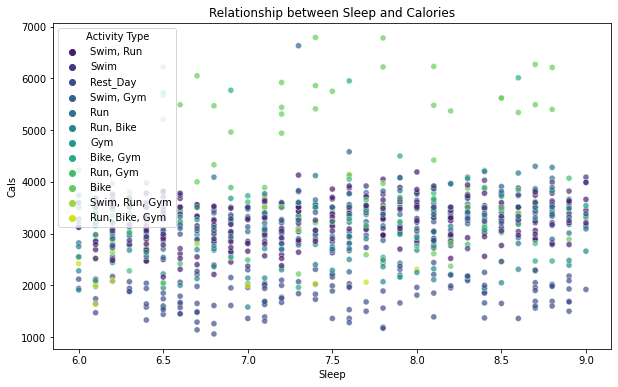

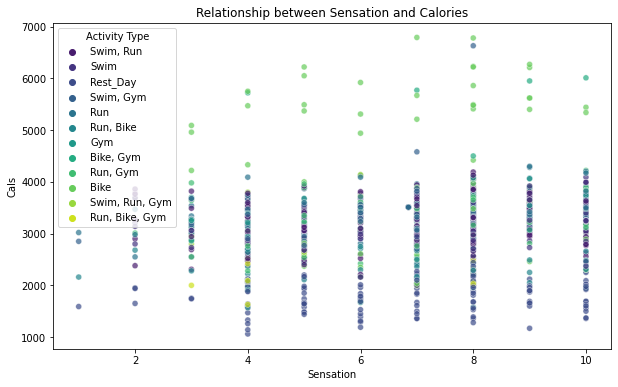

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_of_interest = ['TSS', 'Steps', 'Weight', 'Sleep', 'Sensation']

for var in variables_of_interest:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=var, y='Cals', hue='Activity Type', palette='viridis', alpha=0.7)
    plt.title(f'Relationship between {var} and Calories')
    plt.show()

# Alternatively, for a holistic view, you can use pair plots:
# sns.pairplot(df, vars=['Calories'] + variables_of_interest, hue='Activity Type')

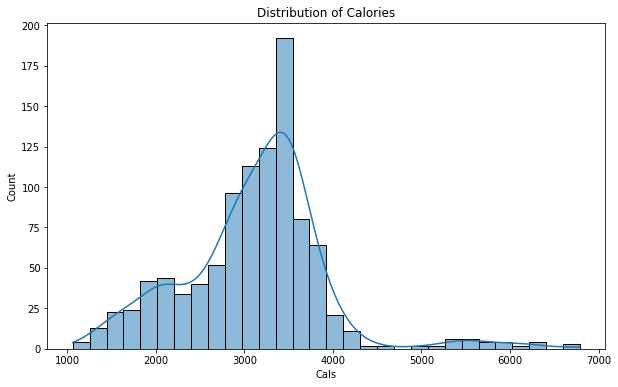

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Cals'], kde=True, bins=30)
plt.title('Distribution of Calories')
plt.show()

In [11]:
grouped_data = df.groupby('Activity Type').agg({
    'TSS': 'mean',
    'Steps': 'mean',
    'Cals': 'mean',
    'Weight': 'mean',
    'Sleep': 'mean',
    'Sensation': 'mean'
}).reset_index()

print(grouped_data)


     Activity Type         TSS         Steps         Cals     Weight  \
0             Bike  202.241379   4933.379310  4424.137931  87.231034   
1        Bike, Gym  163.692308   5074.461538  3835.384615  87.553077   
2              Gym   60.727273  11887.509091  3322.909091  87.392727   
3         Rest_Day    3.758389   4878.590604  2013.959732  87.622148   
4              Run   68.023810  11514.660714  3348.154762  87.552917   
5        Run, Bike   79.509434   4787.471698  2369.811321  87.722642   
6   Run, Bike, Gym   75.538462   5253.461538  2484.615385  88.646154   
7         Run, Gym   79.034483  11198.827586  3302.758621  88.056724   
8             Swim   63.185714  11872.185714  3285.428571  87.802071   
9        Swim, Gym   68.985714  11651.700000  3344.857143  87.674286   
10       Swim, Run   64.069124  11340.995392  3217.373272  87.759908   
11  Swim, Run, Gym   59.250000  12015.050000  3207.000000  86.830000   

       Sleep  Sensation  
0   7.603448   7.038807  
1   7.78461

NameError: name 'count_date' is not defined

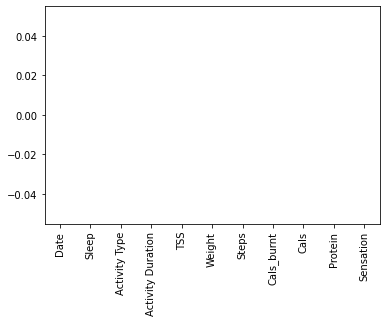

In [12]:
nan_counts = df.isna().sum()

# Plotting the NaN counts
nan_counts.plot(kind='bar', color='skyblue')
plt.title(f'Number of NaN values in each column / {count_date}')
plt.ylabel('Count')
plt.xlabel('Column Name')
plt.show()

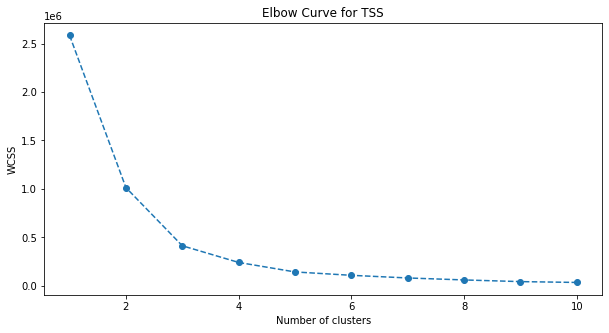

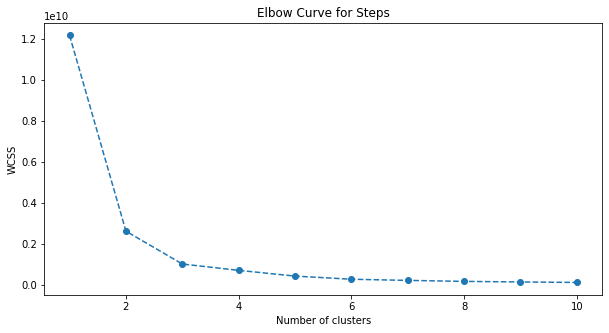

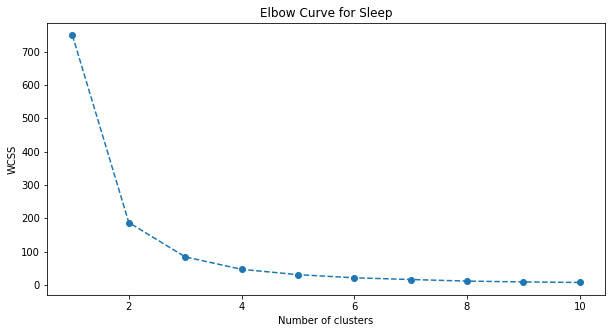

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features_to_bin = ['TSS', 'Steps', 'Sleep']
scaled_data = StandardScaler().fit_transform(df[features_to_bin])

elbow_data = {}
for feature in features_to_bin:
    wcss = []
    for i in range(1, 11):  # trying out 1 to 10 clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(df[[feature]])
        wcss.append(kmeans.inertia_)
    elbow_data[feature] = wcss

# Plotting the elbow curves for each feature
for feature, wcss in elbow_data.items():
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title(f'Elbow Curve for {feature}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


In [14]:
# Example binning for TSS
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df['TSS_bins'] = kmeans.fit_predict(df[['TSS']])
df['TSS_bins'] = df['TSS_bins'].map({0: 'low', 1: 'medium', 2: 'high'})  # replace cluster numbers with labels


kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df['Steps_bins'] = kmeans.fit_predict(df[['Steps']])
df['Steps_bins'] = df['Steps_bins'].map({0: 'low', 1: 'medium', 2: 'high'})  # replace cluster numbers with labels

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df['Sleep_bins'] = kmeans.fit_predict(df[['Sleep']])
df['Sleep_bins'] = df['Sleep_bins'].map({0: 'low', 1: 'medium', 2: 'high'})  # replace cluster numbers with labels
# Repeat similar steps for `Steps` and `Sleep` based on their elbow plots


/tmp/ipykernel_2936/1111422959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TSS_bins'] = kmeans.fit_predict(df[['TSS']])
/tmp/ipykernel_2936/1111422959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TSS_bins'] = df['TSS_bins'].map({0: 'low', 1: 'medium', 2: 'high'})  # replace cluster numbers with labels
/tmp/ipykernel_2936/1111422959.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_2936/146359564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Activity_Type_Encoded'] = le.fit_transform(df['Activity Type'])


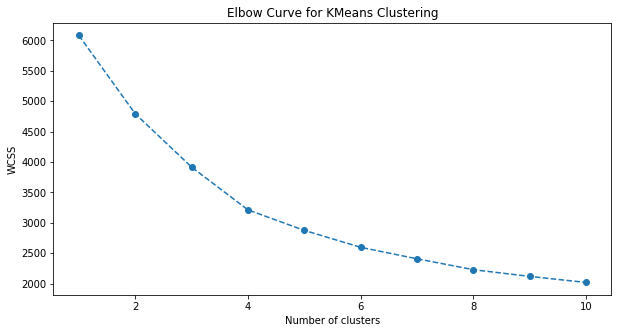

In [15]:
from sklearn.preprocessing import LabelEncoder

# If Activity Type is categorical, encode it
le = LabelEncoder()
df['Activity_Type_Encoded'] = le.fit_transform(df['Activity Type'])

# Selecting features for clustering
features_for_clustering = ['TSS', 'Steps', 'Weight', 'Sleep', 'Sensation', 'Activity_Type_Encoded']

# Scaling the data
scaled_data_clustering = StandardScaler().fit_transform(df[features_for_clustering])

# Using the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data_clustering)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Curve for KMeans Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [16]:
optimal_clusters = 4  # Replace with the number you deduce from the Elbow Curve
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data_clustering)


/tmp/ipykernel_2936/2641776850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = kmeans.fit_predict(scaled_data_clustering)


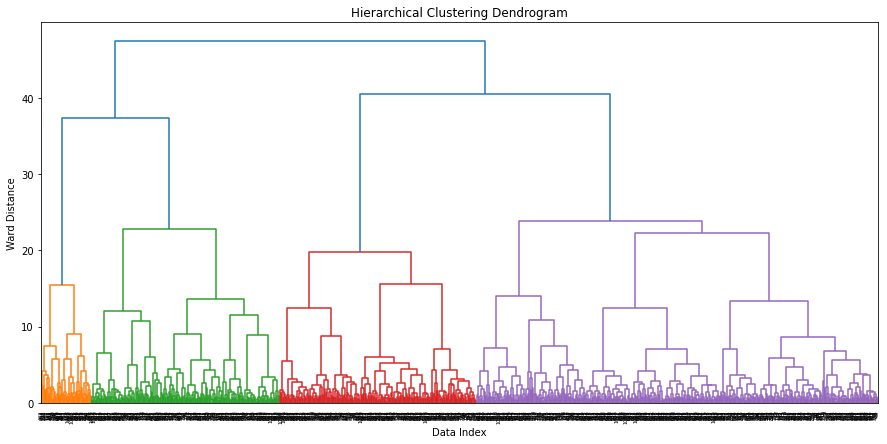

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Using Ward linkage for Hierarchical Clustering
linked = linkage(scaled_data_clustering, 'ward')

plt.figure(figsize=(15, 7))
dendrogram(linked, orientation='top')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Index')
plt.ylabel('Ward Distance')
plt.show()


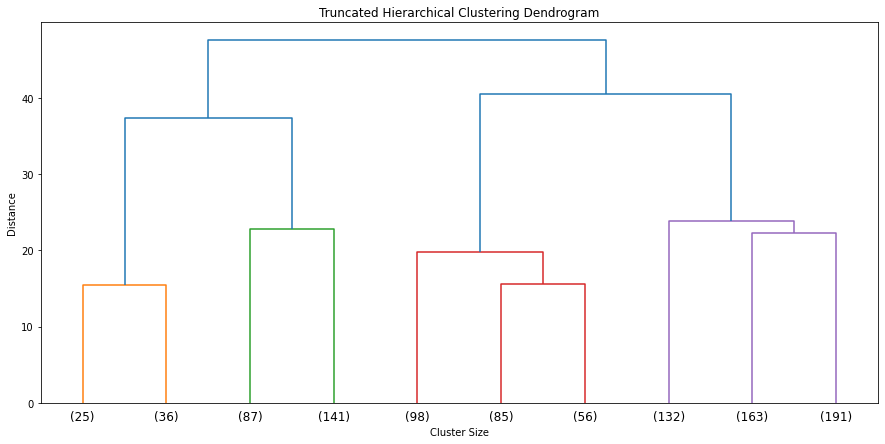

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Using Ward linkage for Hierarchical Clustering
linked = linkage(scaled_data_clustering, 'ward')

plt.figure(figsize=(15, 7))
dendrogram(linked, orientation='top', truncate_mode='lastp', p=10, show_leaf_counts=True)  # Show only the last 10 merged clusters
plt.title('Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [19]:
for column in ["TSS_bins", "Steps_bins", "Sleep_bins"]:
    print(df[column].value_counts())
    print("-------------------------")


medium    793
low       181
high       40
Name: TSS_bins, dtype: int64
-------------------------
low       383
high      338
medium    293
Name: Steps_bins, dtype: int64
-------------------------
medium    362
high      336
low       316
Name: Sleep_bins, dtype: int64
-------------------------


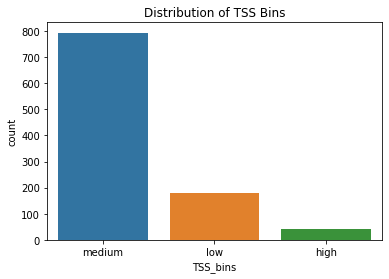

In [20]:
import seaborn as sns

sns.countplot(data=df, x='TSS_bins').set_title('Distribution of TSS Bins')
plt.show()


In [21]:
cross_tab = pd.crosstab(df['TSS_bins'], df['Activity Type'])
print(cross_tab)


Activity Type  Bike  Bike, Gym  Gym  Rest_Day  Run  Run, Bike  Run, Bike, Gym  \
TSS_bins                                                                        
high             34          5    0         0    0          0               0   
low               0          0    1       143   24          2               0   
medium           24          8   54         6  144         51              13   

Activity Type  Run, Gym  Swim  Swim, Gym  Swim, Run  Swim, Run, Gym  
TSS_bins                                                             
high                  0     0          1          0               0  
low                   0     3          1          6               1  
medium               58   137         68        211              19  


In [22]:
df

,Date,Sleep,Activity Type,Activity Duration,TSS,Weight,Steps,Cals_burnt,Cals,Protein,Sensation,TSS_bins,Steps_bins,Sleep_bins,Activity_Type_Encoded,Cluster
0,22/05/2017,7.1,"Swim, Run",125.0,154,87.7,13894.0,4600.0,3600.0,135.0,7.0,medium,low,high,10,2
1,23/05/2017,6.3,Swim,45.0,78,87.7,12739.0,3459.0,3700.0,75.0,4.0,medium,low,low,8,2
2,24/05/2017,6.7,Rest_Day,0.0,0,87.7,3324.0,2629.0,2210.0,75.0,8.0,low,medium,low,3,0
3,25/05/2017,7.6,"Swim, Gym",142.0,155,87.7,11532.0,4327.0,4580.0,120.0,7.0,medium,high,high,9,1
4,26/05/2017,8.7,Run,68.0,60,87.7,10479.0,3363.0,3590.0,80.0,9.0,medium,high,medium,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,16/03/2020,8.0,Swim,60.0,60,90.6,11490.0,3414.0,3250.0,75.0,10.0,medium,high,medium,8,1
1030,17/03/2020,8.1,Swim,60.0,67,90.6,11011.0,3405.0,2870.0,75.0,8.0,medium,high,medium,8,1
1031,18/03/2020,6.6,Rest_Day,0.0,0,90.6,6475.0,2091.0,1790.0,80.0,6.0,low,medium,low,3,0
1032,19/03/2020,8.4,"Swim, Run",60.0,68,90.6,11595.0,3543.0,3780.0,80.0,9.0,medium,low,medium,10,1


# following Le Wagon method

<AxesSubplot:>

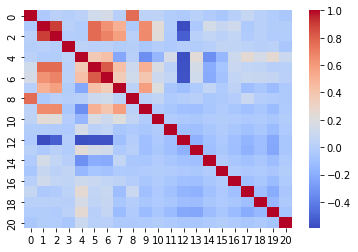

In [23]:
import seaborn as sns

sns.heatmap(pd.DataFrame(df_processed).corr(), cmap='coolwarm')

In [24]:
## Comput Picincpal Components 

In [25]:
df_processedWG = df_processed

In [26]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_processedWG)

PCA()

In [27]:
X_proj = pca.transform(df_processedWG)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 22)])
X_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,3.585854,0.701330,0.153020,-0.021532,1.750251,-1.091378,-0.872872,-0.345996,-0.375875,0.252142,...,-0.228471,-0.012018,0.028204,0.170737,0.025139,0.086267,0.349917,0.088943,-0.198043,5.540572e-17
1,0.141480,1.496776,-1.625749,0.116563,0.185658,0.233133,0.493995,0.041061,0.842408,0.084014,...,0.043069,0.001671,-0.045169,0.150259,-0.087864,-0.036684,-0.133735,0.018910,0.059170,-3.653463e-17
2,-2.701748,0.325751,1.359993,-0.168390,0.054736,-0.228906,1.272774,0.108611,-0.337686,0.575590,...,-0.036883,0.005002,-0.009990,0.156588,-0.123196,-0.010510,-0.117169,-0.009234,-0.054272,-7.816799e-17
3,3.825915,0.270072,0.299325,-0.030644,0.798283,0.026858,-0.018015,-0.156422,0.334723,-0.167316,...,-0.599951,0.602506,-0.097988,-0.037418,-0.057577,0.119356,0.389269,0.019541,-0.262052,-1.614347e-16
4,0.403696,-1.742012,0.009599,0.010822,-0.024500,0.386192,0.082330,0.303082,-0.282956,-0.649519,...,0.376273,0.060031,-0.034291,-0.192236,0.038920,0.027176,0.124764,-0.032450,-0.047295,-1.059236e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.090297,-1.610449,-0.427073,-1.337465,-0.142405,-0.643992,0.337374,0.227850,0.679560,0.161380,...,0.233167,0.059673,0.012399,-0.048476,-0.015836,-0.011210,-0.010765,-0.026236,-0.017164,-1.198014e-16
1010,-0.116138,-0.974682,-0.356662,-1.347106,-0.253974,-0.201581,-0.313949,0.377684,0.669399,0.188289,...,0.147437,0.050290,0.017517,-0.057352,-0.042277,0.006529,-0.025926,-0.030753,-0.032308,-9.204578e-17
1011,-3.149879,1.004018,0.707781,-1.476271,0.541546,-0.233730,0.379139,0.054881,-0.009458,0.092134,...,-0.200603,-0.079139,-0.029227,-0.069128,0.189007,-0.045973,0.201128,-0.003140,0.053216,-1.614347e-16
1012,0.627980,-1.608567,-0.537161,-1.325158,0.058633,0.036942,0.000038,-0.819326,-0.267393,0.037885,...,0.090081,0.019235,0.005519,0.045324,-0.011118,0.003586,-0.021254,0.006867,-0.008210,-2.786101e-17


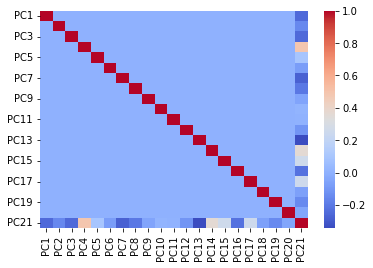

In [28]:
sns.heatmap(X_proj.corr(), cmap='coolwarm');

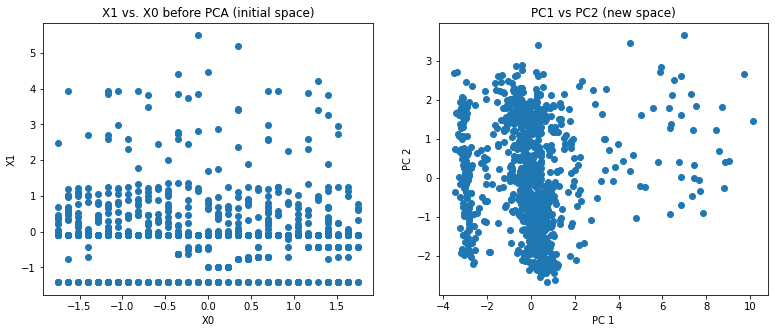

In [29]:
# 2D-slice

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial space)'); plt.xlabel('X0'); plt.ylabel('X1')
plt.scatter(df_processedWG.iloc[:,0], df_processedWG.iloc[:,1])

plt.subplot(1,2,2)
plt.title('PC1 vs PC2 (new space)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1]);

In [30]:
from sklearn.cluster import KMeans

# Fit K-means
km = KMeans(n_clusters=3)
km.fit(X_proj)

KMeans(n_clusters=3)

In [31]:
# The 3 centroids' coordinates (expressed in the space of PCs)
km.cluster_centers_.shape

(3, 21)

In [32]:
# The 177 observations are classified automatically
km.labels_

array([2, 1, 0, ..., 0, 1, 0], dtype=int32)

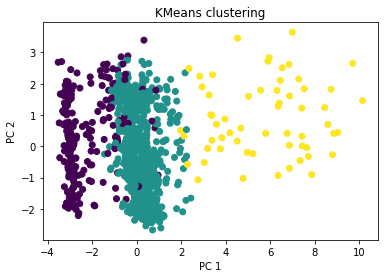

In [33]:
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

NameError: name 'y' is not defined

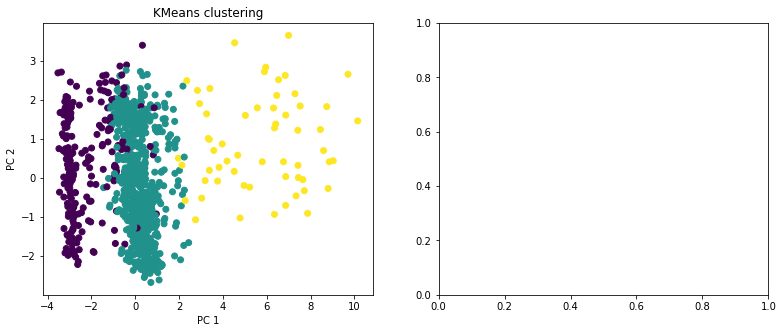

In [34]:
# Visualization
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2')

plt.subplot(1,2,2)
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=y)
plt.title('True wine labels'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

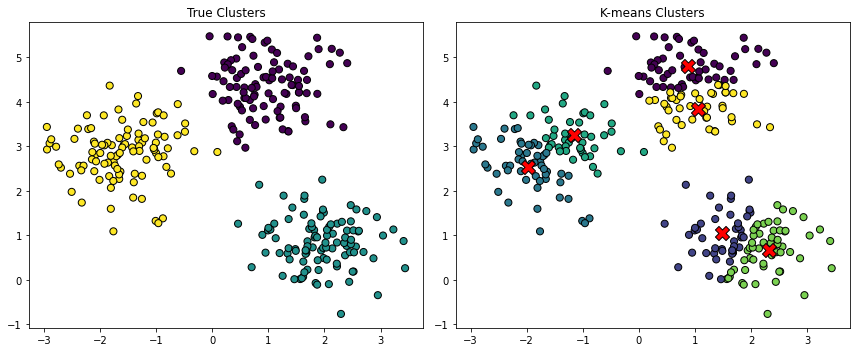

In [35]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate synthetic dataset with 3 clusters
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# Use K-means to cluster the data
kmeans = KMeans(n_clusters=6)
y_kmeans = kmeans.fit_predict(X)

# Visualize the true clusters and the clusters identified by K-means
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# True clusters
ax[0].scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis', edgecolor='k')
ax[0].set_title('True Clusters')

# Clusters identified by K-means
ax[1].scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis', edgecolor='k')
ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', edgecolor='k')
ax[1].set_title('K-means Clusters')

plt.tight_layout()
plt.show()
